In [154]:
import numpy as np
import pandas as pd
import pickle
import project_tools as tools
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Read all Data into Notebook
original_stats = tools.get_weekly_stats()
original_games = tools.get_data('games', 2004)
original_records = tools.get_data('records', 2004)
original_teams = pd.read_json('https://api.collegefootballdata.com/teams')

In [22]:
# Reset indecis of all dataframes
original_stats = original_stats.reset_index(drop=True)
original_games = original_games.reset_index(drop=True)
original_records = original_records.reset_index(drop=True)
original_teams = original_teams.reset_index(drop=True)

In [24]:
# Save all Data into Pickle File
with open('cfb_data.pkl','wb') as f:
    pickle.dump([original_stats, original_games, original_records, original_teams], f )

In [2]:
# Load all Data into Pickle File
with open('cfb_data.pkl', 'rb') as f:
    original_stats, original_games, original_records, original_teams = pickle.load(f)

In [111]:
games = tools.get_games_df('train')

In [112]:
games

,season,week,home_team,away_team,result,home_games,away_games,firstDowns_spread,fourthDownConversions_spread,fourthDowns_spread,...,thirdDownConversions_spread,thirdDowns_spread,totalYards_spread,turnovers_spread,home_for,home_against,away_for,away_against,away_wins,home_wins
0,2004,1,Virginia Tech,USC,-11.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,2004,2,Eastern Michigan,Buffalo,3.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,2004,2,Utah,Texas A&M,20.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,2004,2,Ball State,Boston College,-8.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,2004,2,TCU,Northwestern,3.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10453,2018,14,Georgia,Alabama,-7.0,12.0,12.0,0.750000,0.166667,-0.083333,...,0.166667,0.750000,2.666667,0.083333,40.083333,17.166667,49.000000,13.750000,11.0,10.0
10454,2018,14,Boise State,Fresno State,-3.0,12.0,12.0,1.333333,0.500000,0.916667,...,1.416667,1.166667,-2.083333,0.250000,37.000000,22.333333,36.250000,13.500000,9.0,11.0
10455,2018,14,Ohio State,Northwestern,21.0,12.0,12.0,8.083333,0.000000,-0.750000,...,0.166667,-2.000000,190.666667,0.000000,43.333333,25.833333,23.666667,21.666667,8.0,11.0
10456,2018,14,Pittsburgh,Clemson,-32.0,12.0,12.0,-3.083333,0.000000,0.333333,...,0.083333,1.500000,-107.250000,-0.250000,28.000000,27.750000,45.666667,14.000000,11.0,6.0


## Single Variable Linear Regression

In [113]:
pd.options.display.max_columns = None
train = games[games['season'] < 2018]
valid = games[games['season'] == 2018]

X_train = train['totalYards_spread'].to_numpy()
y_train = train['result'].to_numpy()

X_valid = valid['totalYards_spread'].to_numpy()
y_valid = valid['result'].to_numpy()

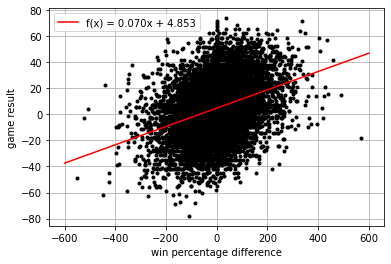

In [115]:
baseline_model = LinearRegression().fit(X_train.reshape(-1, 1), y_train)

x = np.linspace(-600, 600, 500)
y = baseline_model.coef_[0] * x + baseline_model.intercept_

plt.xlabel('win percentage difference')
plt.ylabel('game result')
plt.plot(X_train, y_train, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (baseline_model.coef_[0], baseline_model.intercept_))
plt.legend()
plt.grid()

In [116]:
prediction_train = baseline_model.predict(X_train.reshape(-1, 1))
prediction_valid = baseline_model.predict(X_valid.reshape(-1, 1))
print('RMSE on train = %.2f points' % mean_squared_error(y_train, prediction_train, squared=False))
print('RMSE on valid = %.2f points' % mean_squared_error(y_valid, prediction_valid, squared=False))

RMSE on train = 19.91 points
RMSE on valid = 21.11 points


## Ridge Regression Baseline

In [128]:
X= games.drop(['home_team','away_team','result'], axis=1).to_numpy()
y = games['result']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

In [129]:
LinRegMod = Ridge(alpha=1.0)
LinRegMod.fit(X_train, y_train)

Ridge()

In [130]:
pred_train = LinRegMod.predict(X_train)
print('RMSE on train = %.2f points' % mean_squared_error(y_train, pred_train, squared=False))
print(f'Percent Correct (W/L) = {np.sum(np.sign(pred_train)==np.sign(y_train))/len(y_train)*100:.4}%\n')

pred_valid = LinRegMod.predict(X_valid)
print('RMSE on valid = %.2f points' % mean_squared_error(y_valid, pred_valid, squared=False))
print(f'Percent Correct (W/L) = {np.sum(np.sign(pred_valid)==np.sign(y_valid))/len(y_valid)*100:.4}%')

RMSE on train = 17.85 points
Percent Correct (W/L) = 70.51%

RMSE on valid = 17.75 points
Percent Correct (W/L) = 70.08%


In [131]:
alphas = np.linspace(0, 2, 1000)
train_loss = []
valid_loss = []
for alpha in alphas:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    LinRegMod = Ridge(alpha=alpha)
    LinRegMod.fit(X_train, y_train)
    pred_valid = LinRegMod.predict(X_valid)
    pred_train = LinRegMod.predict(X_train)
    train_loss.append(mean_squared_error(y_train, pred_train, squared=False))
    valid_loss.append(mean_squared_error(y_valid, pred_valid, squared=False))

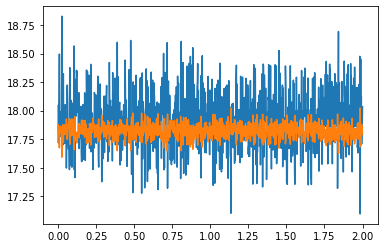

In [132]:
plt.plot(alphas,valid_loss)
plt.plot(alphas,train_loss)

## Playing around with a Neural Net

In [163]:
torch.manual_seed(0)
device = torch.device("cpu")
print('Using device', device)

Using device cpu


In [164]:
# Prepare Data
X_train = torch.tensor(games.drop(['home_team','away_team','result'], axis=1).to_numpy())
y_train = torch.tensor(games['result'])
print(y.size())
print(X.size())

torch.Size([10458])
torch.Size([10458, 36])


In [181]:
train_in = games.drop(columns=['home_team','away_team','result'])
train_out = games.result

data_train_vals = torch.tensor(train_in.to_numpy(), dtype=torch.float, device=device)
data_train_labels = torch.tensor(train_out.to_numpy(), dtype=torch.float, device=device)

data_train = TensorDataset(data_train_vals, data_train_labels)
train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 

In [211]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.h1 = nn.Linear(36, 1)       
        
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.h1(x)
        return x
    
def train(model, device, train_loader, optimizer, epochs, criterion, verbose=False, log_freq = 10):
    for epoch in range(epochs):
        model.train()
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        if verbose & (epoch%log_freq==0):
            print('Train Epoch: %d  \tLoss: %.6f' % (epoch, loss.item()/len(data)))
model = Network()

In [231]:
model = nn.Sequential(nn.Linear(36,1))

In [264]:
BATCH_SIZE = 10458
EPOCHS = 100
LEARNING_RATE = 0.0000001
MOMENTUM = 0.00005

In [265]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [266]:
train(model, device, train_loader, optimizer, EPOCHS, criterion, verbose=True)

/Users/jhrag/opt/anaconda3/envs/ee511/lib/python3.9/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jhrag/opt/anaconda3/envs/ee511/lib/python3.9/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 0  	Loss: 14.141275
Train Epoch: 10  	Loss: 27.226220
Train Epoch: 20  	Loss: 14.480957
Train Epoch: 30  	Loss: 14.313484
Train Epoch: 40  	Loss: 23.511364
Train Epoch: 50  	Loss: 24.157180
Train Epoch: 60  	Loss: 11.251363
Train Epoch: 70  	Loss: 18.246010
Train Epoch: 80  	Loss: 15.482465
Train Epoch: 90  	Loss: 12.670204


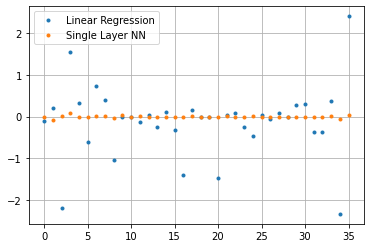

In [267]:
nn_weights = model[0].weight.detach().numpy().T
lreg_weights = LinRegMod.coef_

plt.plot(lreg_weights, '.')
plt.plot(nn_weights, '.')
plt.grid()
plt.legend(['Linear Regression','Single Layer NN'])